<h2> Custom Stacking</h2>

<h3> Steps Involved for building Custom Stacking </h3> <br>
<h5>
1. Splitting my dataset into 3 parts train and test into 80:20 ratio and then splitting train into dataset1 and dataset2 into 50:50 ratio. <br>
2. Dataset1 is being used to fit our base-leaners. Here decision tree is base-learner. Considering n number of base-learners n number of sampled data would be generated and training the n models with their corresponding sampled data. <br>
3. After training the models that models would be stored into the list.<br>
4. Now with dataset-2, n models would predict n predictions.After getting these predictions stored the predcitions and stack them to make a prediction dataset lets say stacked-dataset.<br>
5. Here we would be using meta-classifier. I have used logistic regression and trained my metaclassifier with stacked dataset. <br>
6. Now testdataset is being passed to n number of trained dataset which will give n number of predictions and stored and stacked to create test stacked dataset. <br>
7. These test stacked dataset is used to get predictions from my metaclassifier and used for models evaluation.<br>
<b>Note</b>: For MetaClassifier our target variable would be target variable of the corresponding dataset <br> </h5>


<h3> Libraries </h3>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt  
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
from scipy.sparse import hstack
from google.colab import files
from sklearn.linear_model import LogisticRegression
import tqdm.notebook as tq
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable


In [ ]:
uploaded=files.upload()

Saving age_iloan.csv to age_iloan.csv


Here I have loaded already preprocessed data.

In [ ]:
data=pd.read_csv('age_iloan.csv',sep=",")
data.columns

Index(['age_group', 'job', 'marital', 'education', 'default', 'i_loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

<h3> Splitting Dataset </h3> 

Here I have split my dataset into 2 First on Train and test with the ration of 80:20. Again I have splitted my train dataset into 50:50

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.20, random_state=42)

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.20, random_state=42)
dataset1,dataset2=train_test_split(X_train, test_size=0.50, random_state=42)
print(dataset1.shape)
print(dataset2.shape)
print(X_test.shape)

(16464, 20)
(16464, 20)
(8233, 20)


<h3> Response Encoding </h3>

In [ ]:
"""this function takes the train dataset and tries to fit the categories and return the positve and negative probablity of each feature
This function is more like fit function that is present in sklearn count_vectoriser """
def response_encoding(feature,y_values):  
    #taking unique values from features and converting it into list.
    unique_values=np.unique(feature).tolist()
    
    y_values=pd.DataFrame(data=y_values)
    df=pd.DataFrame({'feature':feature.values.tolist(),'y_values':y_values.values.flatten().tolist()})
    negative={}
    positive={}
    for values in unique_values:
        count_positive=len(df[(df['feature']==values) & (df['y_values']==1)]) 
        count_negative=len(df[(df['feature']==values) & (df['y_values']==0)])
        negative[values]=count_negative/(count_negative+count_positive)
        positive[values]=count_positive/(count_negative+count_positive)
    return positive,negative

In [ ]:
"""this function is used to transform our dataset based on our fit train dataset. If the category is present it will replace the it with
positive and negative probablity computed during fit function if category is not present it would it with 0.5 probablity for both
positive and negative."""
def transform_response_encoding(feature,positive,negative,y_test_values):
    unique_list=np.unique(feature).tolist()
   
    y_test_values=pd.DataFrame(data=y_test_values)
    dataframe=pd.DataFrame({'feature':feature.values.tolist(),'y_test_values':y_test_values.values.flatten().tolist()})
    
    negative_test={}
    positive_test={}
    for value in unique_list:
        #value which is not present in training data probablity values would be 0.5
        if value not in positive.keys() and negative.keys():
           
            negative_test[value]=0.5
            positive_test[value]=0.5
        else:
            negative_test[value]=negative[value]
            positive_test[value]=positive[value]
    return positive_test,negative_test

In [ ]:
"""In this function I am sending my dataset and all my categories in dataset in which I have to fit my K 
number of models has been fitted."""
def fitting_encoding_of_features(data):
    response_encoding_dictionary={}
    #creating new dataframe to store all categories and returing dataframe and dictionary
    new_data=pd.DataFrame()
    for feature in ['age_group', 'job', 'marital', 'education', 'default', 'i_loan', 'contact', 'month', 'day_of_week', 'poutcome']:
        positive_values_train,negative_values_train=response_encoding(data[feature],data['y'])
        variable1=feature+'_'+'positive'
        variable2=feature+'_'+'negative'
        new_data[variable1]=data[feature].map(positive_values_train)
        new_data[variable2]=data[feature].map(negative_values_train)
        response_encoding_dictionary[feature]=[positive_values_train,negative_values_train]
     
    return new_data,response_encoding_dictionary   


In [ ]:
"""In this function I have passed my dataset in which we have to transform along with the dictionary
and returning the dataframe"""
def transform_encoding_of_features(data,dictionary):
    new_data=pd.DataFrame()
    
    for feature in ['age_group', 'job', 'marital', 'education', 'default', 'i_loan', 'contact', 'month', 'day_of_week', 'poutcome']:
        positive_values,negative_values=transform_response_encoding(data[feature],dictionary[feature][0],dictionary[feature][1],data['y'])
        variable1=feature+'_'+'positive'
        variable2=feature+'_'+'negative'
        new_data[variable1]=data[feature].map(positive_values)
        new_data[variable2]=data[feature].map(negative_values)
    return new_data   



In [ ]:
new_dataset1,dictionary=fitting_encoding_of_features(dataset1)
print(new_dataset1.shape)
new_dataset2=transform_encoding_of_features(dataset2,dictionary)
print(new_dataset2.shape)

(16464, 20)
(16464, 20)


In [ ]:
test_dataset=transform_encoding_of_features(X_test,dictionary)

In [ ]:
print(test_dataset.shape)

(8233, 20)


In [ ]:
"""In this function I am merging my all numerical data with corresponding dataset. Here I have not included pdays and duration category"""
def merging_columns(new_dataset,dataset):
    data=new_dataset
    for columns in ['campaign','previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed','y']:
        data=pd.concat([data,dataset[columns]],axis=1)
    return data  

In [ ]:
merged_dataset1=merging_columns(new_dataset1,dataset1)

In [ ]:
merged_dataset2=merging_columns(new_dataset2,dataset2)

In [ ]:
test_merged=merging_columns(test_dataset,X_test)
print(test_merged)

       age_group_positive  age_group_negative  ...  nr.employed  y
12469            0.079990            0.920010  ...       5228.1  0
16106            0.098625            0.901375  ...       5228.1  0
144              0.092959            0.907041  ...       5191.0  0
6442             0.145529            0.854471  ...       5191.0  0
39989            0.145529            0.854471  ...       4991.6  0
...                   ...                 ...  ...          ... ..
6098             0.092959            0.907041  ...       5191.0  0
6252             0.145529            0.854471  ...       5191.0  0
23941            0.145529            0.854471  ...       5228.1  0
13104            0.098625            0.901375  ...       5228.1  0
17210            0.079990            0.920010  ...       5228.1  0

[8233 rows x 28 columns]


<h3> Creating Custom Bagging Model</h3>

In [ ]:
"""In this function I am creating N models. For N models I am creating N dataset with sampling with 
replacemnt and fitting to the models so that they can predict on our unseen data. After fitting it is 
being stored into the list and has been returned. Here my base learnes is my decision tree."""
def bagging_models(n_estimators,merged_dataset1):
    models_list=[]
    for index in tq.tqdm(range(0,n_estimators)):
        #sample_data is row sampling with replacement which will give twice the dataset in which are performing. 
        sample_data=merged_dataset1.sample(frac=2,replace=True,random_state=None)
        y1=sample_data['y']
        sample_data.drop('y',axis=1,inplace=True)
        dt=DecisionTreeClassifier(max_depth= 50,min_samples_split=5)
        dt.fit(sample_data,y1)
        models_list.append(dt)
    return models_list    





In [ ]:
"""Here I am passing my first unseen data to get the predictions from all the basemodels
 and storing each predictions into the list"""
def predicting_bagging_models(models,data):
    y_prediction=[]
    y2=data['y']
    data.drop('y',axis=1,inplace=True)
    for model in tq.tqdm(models):
        y_hat=model.predict(data)
        y_prediction.append(y_hat)
    return y_prediction    




In [ ]:
"""In this prediction I have send all my predictions and creating into a dataset."""
def stacking_prediction(prediction):
    pred_values=np.reshape(prediction[0],(len(prediction[0]),1))
    for index in tq.tqdm(range(1,len(prediction))):
        val=np.reshape(prediction[index],(len(prediction[index]),1))
        pred_values=np.hstack((pred_values,val))
    return pred_values 

In [ ]:
models=bagging_models(2000,merged_dataset1)

In [ ]:
prediction=predicting_bagging_models(models,merged_dataset2)

In [ ]:
test_prediction=predicting_bagging_models(models,test_merged)

In [ ]:

stacked_dataset=stacking_prediction(prediction)



In [ ]:
test_stacked_dataset=stacking_prediction(test_prediction)


<h3> Hypertuning Meta-Classifier </h3>

In [ ]:

lr=LogisticRegression(penalty='l2',class_weight='balanced',random_state=42)
params={'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
clf = RandomizedSearchCV(lr, params, random_state=0,return_train_score=True,cv=3,scoring='roc_auc',n_jobs=-1)
clf.fit(stacked_dataset,dataset2['y'])
print(clf.best_params_)
print(clf.best_score_)

{'C': 0.0001}

In [ ]:
def batch_predict(clf,data):
    y_data_pred=[]
    tr_loop=data.shape[0]-data.shape[0]%10000
    for i in range(0,tr_loop,10000):
        y_data_pred.extend(clf.predict_proba(data[i:i+10000])[:,1])
        
    if data.shape[0]%10000!=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:

def find_best_threshold(threshold,fpr,tpr):
    t=threshold[np.argmax(tpr*(1-fpr))]
    
    #print("the maximum value of tpr*(1-fpr)",max(tpr*(1-fpr)),"for threshold",np.round(t,3))
    return t

def prediction_with_best_t(proba,threshold):
    #print("theshold",threshold)
    predictions=[]
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
"""this function takes the classifier object,train,test data send it to batch_predict function to calculate the class probablity
belonging to class 1 append the probablity to the list and return it as a list. Then we calculate tpr and fpr values and plot it 
also calculating to get auc score Along printing the confusion matrix of both train and test data of metaclassifier"""
def calculating_roc_auc_score(classifier,train,test,y_train,y_test):
    classifier.fit(train,y_train)
    y_train_predict=batch_predict(classifier,train)
    y_test_predict=batch_predict(classifier,test)
    train_fpr,train_tpr,train_threshold=roc_curve(y_train,y_train_predict)
    test_fpr,test_tpr,test_threshold=roc_curve(y_test,y_test_predict)
    plt.pyplot.plot(train_fpr,train_tpr,label='Train ROC Curve')
    plt.pyplot.plot(test_fpr,test_tpr,label='Test ROC Curve')
    plt.pyplot.legend()
    plt.pyplot.xlabel('FPR')
    plt.pyplot.ylabel('TPR')
    plt.pyplot.title('TPR vs FPR graph')
    plt.pyplot.grid()
    plt.pyplot.show()

 
    print("Train AUC Score",auc(train_fpr,train_tpr))
    print("Test AUC Score",auc(test_fpr,test_tpr))
    print()
    print()
  
  #Printing Confusion matrix on train and test dataset
    fig=plt.pyplot.figure()
    ax=fig.add_subplot(111)
    best_t= find_best_threshold(train_threshold,train_fpr,train_tpr)
    print("Train Confusion Matrix")
    y_train_predicti=prediction_with_best_t(y_train_predict,best_t)
    train_matrix=confusion_matrix(y_train,y_train_predicti)
    sns.heatmap(train_matrix,annot=True,fmt='d')
    plt.pyplot.show(ax)
    print()
    fig=plt.pyplot.figure()
    ax1=fig.add_subplot(111)
    print("Test Cofusion Matrix")
    y_test_predicti=prediction_with_best_t(y_test_predict,best_t)
    test_matrix=confusion_matrix(y_test,y_test_predicti)
    sns.heatmap(test_matrix,annot=True,fmt='d')
    plt.pyplot.show(ax1)
   
    

<h3> Training and Evaluation of Meta-Classifier </h3>

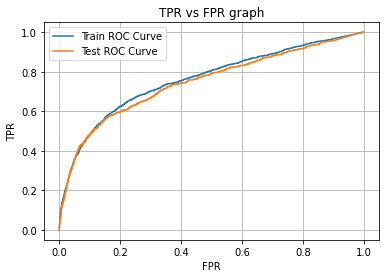

Train AUC Score 0.7614633203958047
Test AUC Score 0.7472532265817246


Train Confusion Matrix


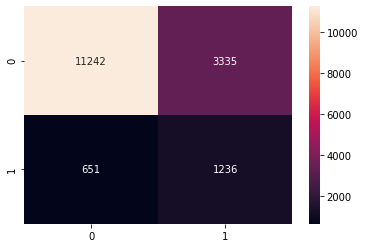


Test Cofusion Matrix


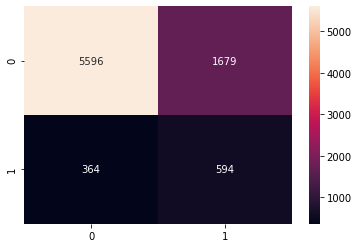

In [ ]:
lr=LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')
calculating_roc_auc_score(lr,stacked_dataset,test_stacked_dataset,dataset2['y'],X_test['y'])


In [ ]:
"""Printing F1-score"""
print("Train F1-Score:",f1_score(dataset2['y'], lr.predict(stacked_dataset), average='macro'))
print("Test F1-Score:",f1_score(X_test['y'], lr.predict(test_stacked_dataset), average='macro'))


Train F1-Score: 0.6527427812658267
Test F1-Score: 0.6513923394605503


<h3> Custom Bagging Model Function </h3>

Here this function do all the steps from splitting the train dataset,response encoding, merging columns, stacking the predictions and training the meta-classifier and getting the predictions from meta-classifier.

In [ ]:
def custom_stacking(X_train,y_train,X_test,n_estimators):
    X_train=pd.concat([X_train,y_train],axis=1)
    print("Splitting Dataset...")
    dataset1,dataset2=train_test_split(X_train, test_size=0.50, random_state=42)
    print("Doing Response Encoding...")
    new_dataset1,dictionary=fitting_encoding_of_features(dataset1) 
    new_dataset2=transform_encoding_of_features(dataset2,dictionary)
    test_dataset=transform_encoding_of_features(X_test,dictionary)
   
    print("Merging the columns...")
    merged_dataset1=merging_columns(new_dataset1,dataset1)
    merged_dataset2=merging_columns(new_dataset2,dataset2)
    test_merged=merging_columns(test_dataset,X_test)

   
    print("Training Base Models...")
    models=bagging_models(n_estimators,merged_dataset1)
    print("Getting predictions from basemodels")
    prediction=predicting_bagging_models(models,merged_dataset2)
    test_prediction=predicting_bagging_models(models,test_merged)
    
    print("Stacking Dataset...")
    stacked_dataset=stacking_prediction(prediction)
    test_stacked_dataset=stacking_prediction(test_prediction)
    print("Fitting Meta Classifier...")
    lr=LogisticRegression(penalty='l2',C=0.0001,class_weight='balanced')
    lr.fit(stacked_dataset,dataset2['y'])
    print("Getting Predictions")
    return lr.predict(test_stacked_dataset)




    



In [ ]:
a=X_train['y']
b=X_train.drop('y',axis=1,inplace=False)
custom_stacking(b,a,X_test,100)


Splitting Dataset...
Doing Response Encoding...
Merging the columns...
(8233, 28)
Training Base Models...



Getting predictions from basemodels



Stacking Dataset...



Fitting Meta Classifier...
Getting Predictions


array([0, 0, 0, ..., 0, 0, 0])

<h3>Obseravtions:</h3> 

In [3]:

x = PrettyTable()
x.field_names=["Model","Encoding","Test-AUC Score","Test Macro F1 Score"]
x.add_row(["Dummy Classifier(Stratified)","One Hot Encoding",0.5092,0.4691])
x.add_row(["KNN-Classifier","One Hot Encoding",0.7077,0.5569])
x.add_row(["Logistic Regression","One Hot Encoding",0.7530,0.6142])
x.add_row(["SGD-LogLoss","One Hot Encoding",0.7442,0.5788])
x.add_row(["SGD-HingeLoss","One Hot Encoding",0.7385,0.5881])
x.add_row(["RandomForest","One Hot Encoding",0.7702,0.6021])
x.add_row(["XGBoost","One Hot Encoding",0.7962,0.6582])
x.add_row(["Adaboost","One Hot Encoding",0.7931,0.6392])
x.add_row(["Dummy Classifier(Stratified)","Response Encoding",0.5033,0.4691])
x.add_row(["KNN-Classifier","Response Encoding",0.7334,0.6067])
x.add_row(["Logistic Regression","Response Encoding",0.7481,0.6729])
x.add_row(["SGD-LogLoss","Response Encoding",0.7475,0.6755])
x.add_row(["SGD-HingeLoss","Response Encoding",0.7425,0.1042])
x.add_row(["RandomForest","Response Encoding",0.7670, 0.5876])
x.add_row(["XGBoost","Response Encoding",0.7973,0.6546])
x.add_row(["Adaboost","Response Encoding",0.7942,0.6793])
x.add_row(["Custom Stacking(200-Decision Tree)","Response Encoding",0.7472,0.6513])
print(x)

+------------------------------------+-------------------+----------------+---------------------+
|               Model                |      Encoding     | Test-AUC Score | Test Macro F1 Score |
+------------------------------------+-------------------+----------------+---------------------+
|    Dummy Classifier(Stratified)    |  One Hot Encoding |     0.5092     |        0.4691       |
|           KNN-Classifier           |  One Hot Encoding |     0.7077     |        0.5569       |
|        Logistic Regression         |  One Hot Encoding |     0.753      |        0.6142       |
|            SGD-LogLoss             |  One Hot Encoding |     0.7442     |        0.5788       |
|           SGD-HingeLoss            |  One Hot Encoding |     0.7385     |        0.5881       |
|            RandomForest            |  One Hot Encoding |     0.7702     |        0.6021       |
|              XGBoost               |  One Hot Encoding |     0.7962     |        0.6582       |
|              Adabo

It is evident from the above observation that XGBoost with response encoding has better Test AUC score than any other model. So for the prediction of datapoints we would be considering XGBoost.